# NLTK Sentiment Analysis on Metaverse Comments

In [1]:
import pandas as pd
import nltk
import string
import itertools
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
comments = pd.read_csv("./comment_files/raw_dataframe.csv")
comments.head()

,published_At,updated_At,author_DisplayName,text_Original,text_Display,like_Count,author_Channel_Id
0,2023-09-28T17:05:17Z,2023-09-28T17:14:39Z,Lex Fridman,Thank you for listening ❤ Here are the timesta...,Thank you for listening ❤ Here are the timesta...,1802,UCSHZKyawb77ixDdsGog4iWA
1,2023-09-29T05:16:01Z,2023-09-29T05:16:01Z,Marnie Khaw,They need to capture the bio frequencies of th...,They need to capture the bio frequencies of th...,0,UCh4_FQeYR0eq3fwsHp4Faew
2,2023-09-29T05:15:31Z,2023-09-29T05:15:31Z,puddles,what a privacy nightmare. imagine doxing yours...,what a privacy nightmare. imagine doxing yours...,0,UCMXbKsFH5gkiCpo1_bgQXAg
3,2023-09-29T05:15:20Z,2023-09-29T05:15:20Z,Dean I,This is ultimately what Neuralink is ie: blend...,This is ultimately what Neuralink is ie: blend...,0,UCBVsn9CZu8c_N6Kr3bvLMYg
4,2023-09-29T05:15:08Z,2023-09-29T05:15:08Z,TheSadilek,It feels like I'm watching real people even th...,It feels like I&#39;m watching real people eve...,0,UCNqLo2tmFfteO7I-GDQjjzA


## Drop Duplicate Records
* Some of the records duplicated during the data scraping & compiling

In [3]:
comments.shape

(5723, 7)

In [4]:
comments = comments.drop_duplicates()
comments.shape

(5635, 7)

## Drop Lex's Comment
* It only contains timestamps and links to the channel's sponsors

In [5]:
comments = comments[comments["author_DisplayName"] != "Lex Fridman"].copy()
comments.head()

,published_At,updated_At,author_DisplayName,text_Original,text_Display,like_Count,author_Channel_Id
1,2023-09-29T05:16:01Z,2023-09-29T05:16:01Z,Marnie Khaw,They need to capture the bio frequencies of th...,They need to capture the bio frequencies of th...,0,UCh4_FQeYR0eq3fwsHp4Faew
2,2023-09-29T05:15:31Z,2023-09-29T05:15:31Z,puddles,what a privacy nightmare. imagine doxing yours...,what a privacy nightmare. imagine doxing yours...,0,UCMXbKsFH5gkiCpo1_bgQXAg
3,2023-09-29T05:15:20Z,2023-09-29T05:15:20Z,Dean I,This is ultimately what Neuralink is ie: blend...,This is ultimately what Neuralink is ie: blend...,0,UCBVsn9CZu8c_N6Kr3bvLMYg
4,2023-09-29T05:15:08Z,2023-09-29T05:15:08Z,TheSadilek,It feels like I'm watching real people even th...,It feels like I&#39;m watching real people eve...,0,UCNqLo2tmFfteO7I-GDQjjzA
5,2023-09-29T05:14:52Z,2023-09-29T05:14:52Z,Johnny Chen,creepy,creepy,0,UC_jk6ekUhhskwWC7FT_oXaA


## Remove Unwanted Punctuation

In [6]:
comments["text_Original"] = comments["text_Original"].str.replace("\n", "", regex=False)
comments["text_Original"] = comments["text_Original"].str.replace(",", " ", regex=False)
comments["text_Original"] = comments["text_Original"].str.replace("?", ".", regex=False)
comments["text_Original"] = comments["text_Original"].str.replace("!", ".", regex=False)

#### List of Special Characters to filter

In [7]:
list_of_chars = string.punctuation.replace(".","")
list_of_chars

'!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~'

In [8]:
translations = str.maketrans("","", list_of_chars)

comments["text_Original"] = comments["text_Original"].str.translate(translations)
comments["text_Original"] = comments["text_Original"].str.replace(".", " ", regex=False)
comments["text_Original"].head() 

1    They need to capture the bio frequencies of th...
2    what a privacy nightmare  imagine doxing yours...
3    This is ultimately what Neuralink is ie blendi...
4    It feels like Im watching real people even tho...
5                                               creepy
Name: text_Original, dtype: object

### Convert Text to Lower Case

In [9]:
comments["text_Original"] = comments["text_Original"].str.lower()
comments["text_Original"].head()

1    they need to capture the bio frequencies of th...
2    what a privacy nightmare  imagine doxing yours...
3    this is ultimately what neuralink is ie blendi...
4    it feels like im watching real people even tho...
5                                               creepy
Name: text_Original, dtype: object

### Strip Extra Whitespace

In [10]:
comments["text_Original"] = comments["text_Original"].apply(lambda x: str(x).strip())
comments["text_Original"].head()


1    they need to capture the bio frequencies of th...
2    what a privacy nightmare  imagine doxing yours...
3    this is ultimately what neuralink is ie blendi...
4    it feels like im watching real people even tho...
5                                               creepy
Name: text_Original, dtype: object

In [11]:
comments.iloc[4,4]

'creepy'

### Tokenize Text

In [12]:
comments["split_Text"] = comments["text_Original"].str.split()
comments["split_Text"]

1       [they, need, to, capture, the, bio, frequencie...
2       [what, a, privacy, nightmare, imagine, doxing,...
3       [this, is, ultimately, what, neuralink, is, ie...
4       [it, feels, like, im, watching, real, people, ...
5                                                [creepy]
                              ...                        
5718    [have, you, interviewed, paul, travers, presid...
5719    [metaverse, only, fans, with, responsive, ai, ...
5720    [the, facial, expressions, do, not, match, the...
5721                                 [they, should, kiss]
5722                  [can, voices, be, transformed, too]
Name: split_Text, Length: 5633, dtype: object

In [13]:
token_text = list(itertools.chain(*comments["split_Text"]))
token_text[:5]

['they', 'need', 'to', 'capture', 'the']

## Top Words in All Comments

In [14]:
nltk.FreqDist(token_text)

FreqDist({'the': 4311, 'to': 2767, 'this': 2536, 'is': 2492, 'a': 2252, 'and': 2141, 'of': 1774, 'i': 1764, 'in': 1662, 'it': 1175, ...})

### Remove Stop Words

In [15]:
stop = nltk.corpus.stopwords.words("english")
stop[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [16]:
removed_sw = [word for word in token_text if not word in stop]

nltk.FreqDist(removed_sw)

FreqDist({'like': 709, 'lex': 659, 'mark': 478, 'people': 466, 'real': 433, 'metaverse': 391, 'would': 358, 'see': 306, 'future': 293, 'one': 292, ...})

## Top 2 word Pairings

In [17]:
nltk.FreqDist(nltk.ngrams(removed_sw, 2))

FreqDist({('looks', 'like'): 85, ('real', 'life'): 77, ('feels', 'like'): 54, ('feel', 'like'): 53, ('uncanny', 'valley'): 51, ('cant', 'wait'): 44, ('mark', 'zuckerberg'): 44, ('quest', '3'): 41, ('real', 'world'): 41, ('meta', 'verse'): 38, ...})

## Top 3 word Parings

In [18]:
nltk.FreqDist(nltk.ngrams(removed_sw, 3))

FreqDist({('ready', 'player', 'one'): 25, ('ive', 'ever', 'seen'): 12, ('black', 'mirror', 'episode'): 11, ('cant', 'wait', 'see'): 9, ('one', 'step', 'closer'): 8, ('well', 'done', 'mark'): 7, ('two', 'monotone', 'people'): 7, ('mark', 'looks', 'like'): 7, ('httpswww', 'youtube', 'comwatch'): 6, ('im', 'blown', 'away'): 6, ...})

## Lemmatization

In [19]:
wnl = nltk.stem.WordNetLemmatizer()
lem_list = [wnl.lemmatize(i) for i in removed_sw]
lem_list[:10]

['need',
 'capture',
 'bio',
 'frequency',
 'body',
 'transmit',
 'wait',
 'that’s',
 'probably',
 'decade']

#### Word Frequencies w/ Lemmatized Text

In [20]:
nltk.FreqDist(lem_list)

FreqDist({'like': 715, 'lex': 659, 'mark': 532, 'people': 483, 'look': 444, 'real': 433, 'metaverse': 391, 'would': 358, 'avatar': 351, 'one': 326, ...})

In [21]:
nltk.FreqDist(nltk.ngrams(lem_list,2))

FreqDist({('look', 'like'): 122, ('feel', 'like'): 107, ('real', 'life'): 78, ('uncanny', 'valley'): 51, ('facial', 'expression'): 49, ('cant', 'wait'): 44, ('mark', 'zuckerberg'): 44, ('quest', '3'): 41, ('real', 'world'): 41, ('lex', 'look'): 40, ...})

In [22]:
nltk.FreqDist(nltk.ngrams(lem_list,3))

FreqDist({('ready', 'player', 'one'): 25, ('ive', 'ever', 'seen'): 12, ('black', 'mirror', 'episode'): 11, ('cant', 'wait', 'see'): 9, ('one', 'step', 'closer'): 8, ('well', 'done', 'mark'): 7, ('two', 'monotone', 'people'): 7, ('mark', 'look', 'like'): 7, ('httpswww', 'youtube', 'comwatch'): 6, ('feel', 'like', 'lex'): 6, ...})

## NLTK Sentiment Analysis

In [23]:
sia = SentimentIntensityAnalyzer()
sentiment = [sia.polarity_scores(comment) for comment in comments["text_Original"]]
sentiment[:5]

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.795, 'pos': 0.205, 'compound': 0.6597},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]

### Create Dataframe from Sentiment Scores

In [24]:
scores_df = pd.DataFrame.from_records(sentiment)
scores_df.head()

,neg,neu,pos,compound
0,0.0,1.000,0.000,0.0000
1,0.0,1.000,0.000,0.0000
2,0.0,1.000,0.000,0.0000
3,0.0,0.795,0.205,0.6597
4,0.0,1.000,0.000,0.0000


### Combine Sentiment Scores w/ Original Dataframe

In [25]:
comment_scores = comments.join(scores_df)
comment_scores.head()

,published_At,updated_At,author_DisplayName,text_Original,text_Display,like_Count,author_Channel_Id,split_Text,neg,neu,pos,compound
1,2023-09-29T05:16:01Z,2023-09-29T05:16:01Z,Marnie Khaw,they need to capture the bio frequencies of th...,They need to capture the bio frequencies of th...,0,UCh4_FQeYR0eq3fwsHp4Faew,"[they, need, to, capture, the, bio, frequencie...",0.0,1.000,0.000,0.0000
2,2023-09-29T05:15:31Z,2023-09-29T05:15:31Z,puddles,what a privacy nightmare imagine doxing yours...,what a privacy nightmare. imagine doxing yours...,0,UCMXbKsFH5gkiCpo1_bgQXAg,"[what, a, privacy, nightmare, imagine, doxing,...",0.0,1.000,0.000,0.0000
3,2023-09-29T05:15:20Z,2023-09-29T05:15:20Z,Dean I,this is ultimately what neuralink is ie blendi...,This is ultimately what Neuralink is ie: blend...,0,UCBVsn9CZu8c_N6Kr3bvLMYg,"[this, is, ultimately, what, neuralink, is, ie...",0.0,0.795,0.205,0.6597
4,2023-09-29T05:15:08Z,2023-09-29T05:15:08Z,TheSadilek,it feels like im watching real people even tho...,It feels like I&#39;m watching real people eve...,0,UCNqLo2tmFfteO7I-GDQjjzA,"[it, feels, like, im, watching, real, people, ...",0.0,1.000,0.000,0.0000
5,2023-09-29T05:14:52Z,2023-09-29T05:14:52Z,Johnny Chen,creepy,creepy,0,UC_jk6ekUhhskwWC7FT_oXaA,[creepy],0.0,1.000,0.000,0.0000


<Axes: xlabel='neg', ylabel='compound'>

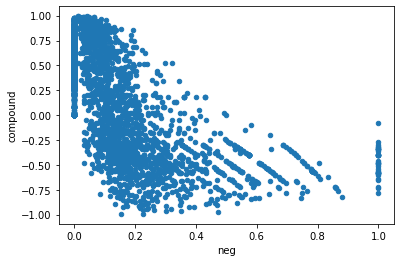

In [26]:
comment_scores.plot.scatter("neg", "compound")

<Axes: xlabel='neu', ylabel='compound'>

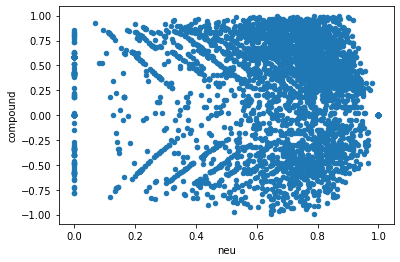

In [27]:
comment_scores.plot.scatter("neu", "compound")

<Axes: xlabel='pos', ylabel='compound'>

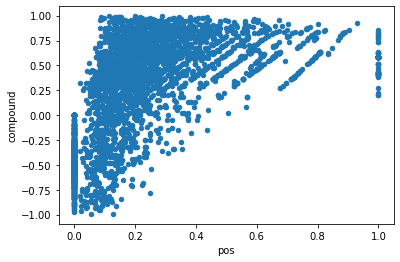

In [28]:
comment_scores.plot.scatter("pos", "compound")

### Word Cloud

In [29]:
text = " ".join(comments["text_Original"])
text

'they need to capture the bio frequencies of their bodies and transmit them too  wait  that’s probably decades away  you can’t imitate the vibrations of every cell in the body what a privacy nightmare  imagine doxing yourself to everyone you interact with on the internet this is ultimately what neuralink is ie blending the physical with the digital without the need for an external device it feels like im watching real people even though theyre virtual  i hope this does not take years to bring to the general public creepy why does lex look way more real than mark pretty soon  well have the only fans metaverse he wont even need to create an ai version of himself  anyone will be able to create an ai version of lax  using the information from all of his content on the web  you can already  for example  ask the ai a question and ask it to respond as jordan peterson  and it will scan the web for all of jordans content and then use that information to respond as him  it will be done similar t

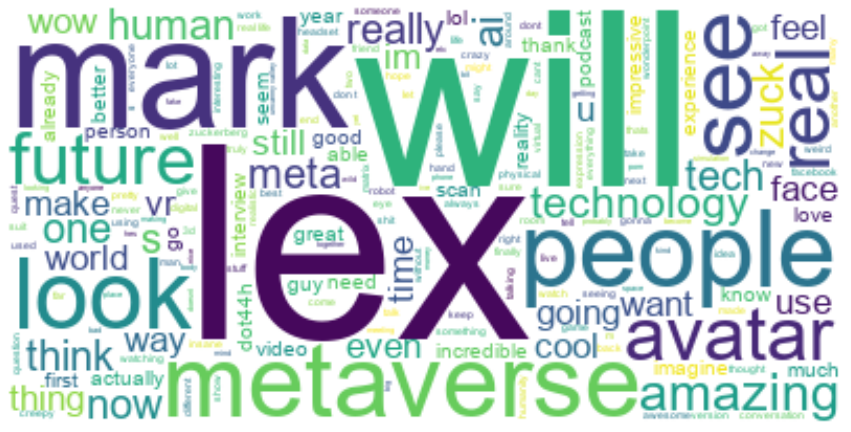

In [38]:
fontpath = "C://Windows/Fonts/arial.ttf"
wordcloud = WordCloud(background_color='white', font_path=fontpath)

wordcloud.generate(text)


plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Word Cloud w/o (lex, mark, & metaverse)

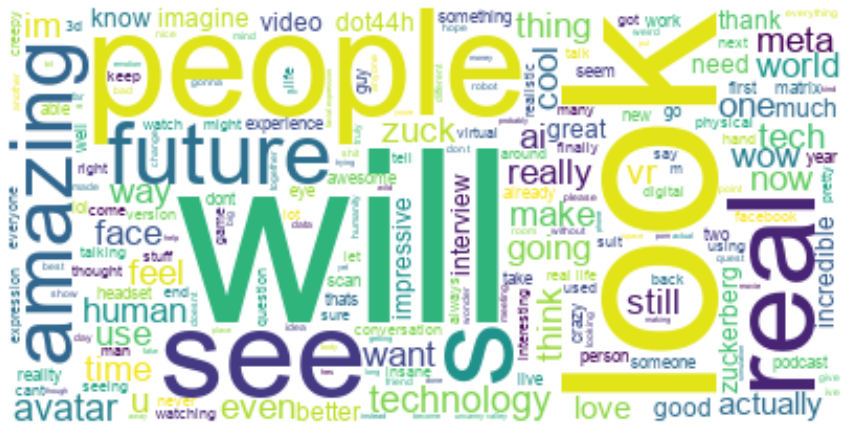

In [44]:
wordcloud = WordCloud(background_color='white', font_path=fontpath)
text = text.replace("lex","")
text = text.replace("mark","")
text = text.replace("metaverse","")
wordcloud.generate(text)


plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()